In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env

# Acquire the Data

In [20]:
# connection function for accessing mysql
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

# query to acquire the zillow data
query = """SELECT bedroomcnt, bathroomcnt,\
        calculatedfinishedsquarefeet, taxvaluedollarcnt, \
        yearbuilt, taxamount, fips \
        FROM properties_2017 \
        LEFT JOIN propertylandusetype USING(propertylandusetypeid)\
        WHERE propertylandusedesc IN ("Single Family Residential",
                                        "Inferred Single Family Residential")"""

# function to get the data and run the query
def get_zillow_data():
    return pd.read_sql(query,get_connection('zillow'))

# acquire the data
df = get_zillow_data()

## Sample and Summarize

In [21]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [22]:
df.shape

(2152864, 7)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2152852.0,3.287196,0.954754,0.00,3.00,3.00,4.00,25.00
bathroomcnt,2152852.0,2.230688,0.999280,0.00,2.00,2.00,3.00,32.00
calculatedfinishedsquarefeet,2144379.0,1862.855178,1222.125124,1.00,1257.00,1623.00,2208.00,952576.00
taxvaluedollarcnt,2152370.0,461896.237963,699676.049600,1.00,188170.25,327671.00,534527.00,98428909.00
yearbuilt,2143526.0,1960.949681,22.162196,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2148421.0,5634.865978,8178.910249,1.85,2534.98,4108.95,6414.32,1337755.86
fips,2152863.0,6048.377335,20.433292,6037.00,6037.00,6037.00,6059.00,6111.00


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152864 entries, 0 to 2152863
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


### Rename Columns

In [24]:
df = df.rename(columns ={'bedroomcnt':'bedrooms',
                         'bathroomcnt':'bathrooms',
                         'calculatedfinishedsquarefeet':'area',
                         'taxvaluedollarcnt':'tax_value',
                         'yearbuilt':'year_built'})

# Prepping the Data

### Finding Null Values

In [25]:
df.isnull().sum()

bedrooms        11
bathrooms       11
area          8485
tax_value      493
year_built    9338
taxamount     4442
fips             0
dtype: int64

### Drop Null Values

In [27]:
# Drop all rows with any Null values, assign to df, and verify.

df = df.dropna()
df.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
taxamount     0
fips          0
dtype: int64

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,2140235.0,3.301419,0.932600,0.00,3.00,3.00,4.00,25.00
bathrooms,2140235.0,2.240352,0.990549,0.00,2.00,2.00,3.00,32.00
area,2140235.0,1863.193970,1221.754161,1.00,1258.00,1623.00,2208.00,952576.00
tax_value,2140235.0,460641.625164,677157.635675,22.00,189166.00,328296.00,534606.00,90188462.00
year_built,2140235.0,1960.967545,22.150563,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2140235.0,5616.711322,7814.562798,6.34,2540.85,4111.47,6411.93,1078101.87
fips,2140235.0,6048.309556,20.344910,6037.00,6037.00,6037.00,6059.00,6111.00


### Dropping Odd Values

In [29]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [30]:
df.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built', 'taxamount',
       'fips'],
      dtype='object')

In [31]:
col_list = ['bedrooms','bathrooms','area','tax_value','taxamount']

In [32]:
df = remove_outliers(df,1.5,col_list)

In [33]:
df.shape

(1854286, 7)

### Visualize Distributions

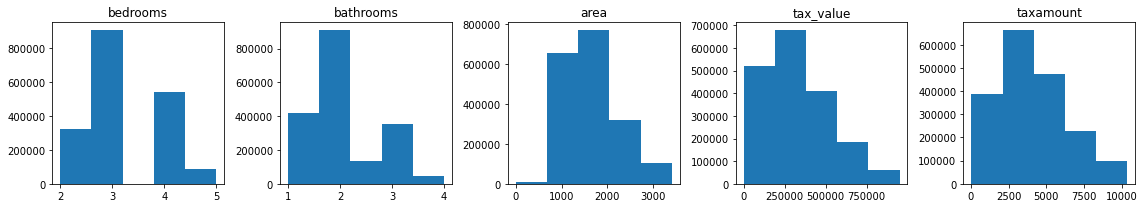

In [34]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
    # mitigate overlap
    plt.tight_layout()
    
plt.show()

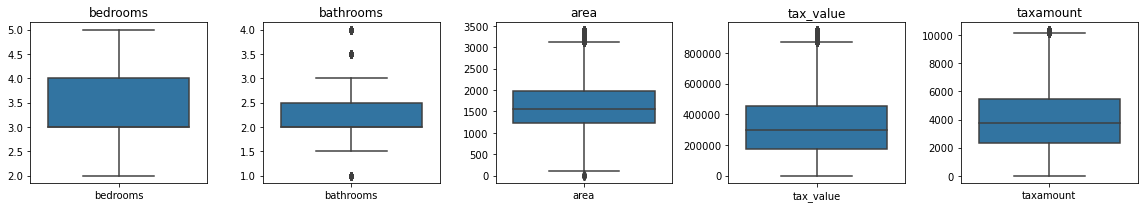

In [35]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount']

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()
    
plt.show()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854286 entries, 6 to 2152863
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   area        float64
 3   tax_value   float64
 4   year_built  float64
 5   taxamount   float64
 6   fips        float64
dtypes: float64(7)
memory usage: 113.2 MB


### Looking at Value Counts

In [38]:
# get value counts and decide on data types
cols = df.columns

for col in cols:
    
    print(col.upper())
    print(df[col].value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print()

BEDROOMS
3.0    904826
4.0    539616
2.0    320442
5.0     89402
Name: bedrooms, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

BATHROOMS
2.00    909424
1.00    385677
3.00    351864
2.50    132322
4.00     31936
1.50     30713
3.50     12347
1.75         3
Name: bathrooms, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

AREA
1200.0    5091
1080.0    4313
1120.0    4286
1400.0    3776
1440.0    3617
          ... 
390.0        1
296.0        1
389.0        1
380.0        1
462.0        1
Name: area, Length: 3013, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

TAX_VALUE
450000.0    806
500000.0    753
400000.0    701
430000.0    677
440000.0    671
           ... 
173116.0      1
535870.0      1
64054.0       1
778669.0      1
366635.0      1
Name: tax_value, Length: 457377, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

YEAR_BUILT
1955.0    80451
1950.0    66875
1954.0    65522
1953.0    58745
1956.0    58053
          ...  
1855.0        1
1874.0        1
1807.0        

In [40]:
# Casting fips and year built as objexts because they are numerical 
# representations of categorical values

df.fips = df.fips.astype(object)
df.year_built = df.year_built.astype(object)


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854286 entries, 6 to 2152863
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   area        float64
 3   tax_value   float64
 4   year_built  object 
 5   taxamount   float64
 6   fips        object 
dtypes: float64(5), object(2)
memory usage: 113.2+ MB
